In [65]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import datasets, metrics, model_selection, svm
import statsmodels.api as sm
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Read in building and electical consumption data</H4>

In [128]:
# read in electricity consumption and building data
kwh_year_df = pd.read_csv('clean-data/kwh_year.csv')

In [4]:
kwh_year_df.head()

,Unnamed: 0,Service Address,avg_kwh,Latitude,Longitude,Parcel Number,prop_id,Effective_YrBlt,Heated_SquareFeet,Stories,kwh_per_sqft,code_release
0,0,2629 NW 55TH BLVD,726.077670,29.705149,-82.361609,6014021030,32391,1977,1498.0,1.0,0.484698,16
1,1,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
2,2,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
3,3,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
4,4,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004017000,78432,2010,1222.0,2.0,2.257671,27


In [129]:
kwh_year_df = kwh_year_df.drop(columns='Unnamed: 0')

In [130]:
kwh_year_df = kwh_year_df.drop(columns=['Service Address'])

In [7]:
# # read in electricity consumption data
# electricity_df = pd.read_csv('data/GRU_Customer_Electric_Consumption.csv')

<h4>Identify colinear features</h4>

In [8]:
kwh_year_df.corr()

,avg_kwh,Latitude,Longitude,Parcel Number,prop_id,Effective_YrBlt,Heated_SquareFeet,Stories,kwh_per_sqft,code_release
avg_kwh,1.000000,-0.079952,-0.018102,0.010132,0.026818,0.063023,0.185103,0.076795,0.508535,0.064757
Latitude,-0.079952,1.000000,-0.134391,-0.377149,-0.498860,0.046609,-0.017014,-0.136254,-0.098716,0.048259
Longitude,-0.018102,-0.134391,1.000000,0.680909,0.775367,-0.262894,-0.091056,-0.083666,0.010590,-0.264918
Parcel Number,0.010132,-0.377149,0.680909,1.000000,0.849588,-0.154652,-0.058992,0.021543,0.048703,-0.155143
prop_id,0.026818,-0.498860,0.775367,0.849588,1.000000,-0.215820,-0.068158,0.010378,0.055169,-0.216317
Effective_YrBlt,0.063023,0.046609,-0.262894,-0.154652,-0.215820,1.000000,0.028064,0.024884,0.069811,0.993516
Heated_SquareFeet,0.185103,-0.017014,-0.091056,-0.058992,-0.068158,0.028064,1.000000,0.474447,-0.035214,0.030020
Stories,0.076795,-0.136254,-0.083666,0.021543,0.010378,0.024884,0.474447,1.000000,-0.067929,0.029459
kwh_per_sqft,0.508535,-0.098716,0.010590,0.048703,0.055169,0.069811,-0.035214,-0.067929,1.000000,0.067824
code_release,0.064757,0.048259,-0.264918,-0.155143,-0.216317,0.993516,0.030020,0.029459,0.067824,1.000000


<h4>Remove colinear features</h4>

In [131]:
col_kwh_year_df = kwh_year_df.drop(columns=['prop_id', 'Stories', 'Effective_YrBlt', 'Latitude', 'Longitude']) 
col_kwh_year_df.columns

Index(['avg_kwh', 'Parcel Number', 'Heated_SquareFeet', 'kwh_per_sqft',
       'code_release'],
      dtype='object')

In [132]:
col_kwh_year_df.head()

,avg_kwh,Parcel Number,Heated_SquareFeet,kwh_per_sqft,code_release
0,726.077670,6014021030,1498.0,0.484698,16
1,2758.873786,9004018000,2971.0,0.928601,18
2,2758.873786,9004018000,2971.0,0.928601,18
3,2758.873786,9004018000,2971.0,0.928601,18
4,2758.873786,9004017000,1222.0,2.257671,27


<h4>Train, test split and instantiate linear regression models</h4>

In [65]:
# y1 = col_kwh_year_df.pop('code_release')
# X1 = col_kwh_year_df

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.25, random_state=1)

In [20]:
# y = col_kwh_year_df.pop('code_release')
# x = col_kwh_year_df

<h4>PCA</h4>

In [11]:
# # standardizing data
# features = ['avg_kwh', 'Latitude', 'Longitude', 'Parcel Number', 'Effective_YrBlt',
#        'Heated_SquareFeet', 'kwh_per_sqft']
# # Separating out the features
# x = col_kwh_year_df.loc[:, features].values
# # Separating out the target
# y = col_kwh_year_df.loc[:,['code_release']].values
# # Standardizing the features
# x = StandardScaler().fit_transform(x)

In [12]:
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['pc1', 'pc2', 'pc3'])

In [13]:
# finalDf = pd.concat([principalDf, col_kwh_year_df[['code_release']]], axis = 1)

In [14]:
# year_list = col_kwh_year_df['code_release'].values

In [15]:
# finalDf.head()

<h4>Define Target variable and feature set</h4>

In [133]:
y = col_kwh_year_df.pop('code_release')
X = col_kwh_year_df

<h4>Train, test split and instantiate linear regression models</h4>

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.80, random_state=1)

In [135]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8615 entries, 5884 to 7186
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_kwh            8615 non-null   float64
 1   Parcel Number      8615 non-null   int64  
 2   Heated_SquareFeet  8615 non-null   float64
 3   kwh_per_sqft       8615 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 336.5 KB


In [40]:
# X_test = X_test.sort_index()
# X_test[:200]

<h4>Set benchmark model</h4>

In [150]:
alpha = 3.0
linear = LinearRegression()
lasso = Lasso()
ridge = Ridge(alpha=alpha)
knn = KNeighborsRegressor(4)

In [151]:
folds = 15
#score = mean_squared_error()
linear_cv = cross_val_score(linear, X, y, cv=folds, scoring='neg_mean_squared_error')
lasso_cv = cross_val_score(lasso, X, y, cv=folds, scoring='neg_mean_squared_error')
ridge_cv = cross_val_score(ridge, X, y, cv=folds, scoring='neg_mean_squared_error')
knn_cv = cross_val_score(knn, X, y, cv=folds, scoring='neg_mean_squared_error')

Ill-conditioned matrix (rcond=2.27985e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.39807e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.33367e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.20004e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.07518e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.35403e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.42852e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.19709e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.50622e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.42159e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.53473e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.46537e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.57096e-19): result may not be accurate.
Ill-conditioned matrix (rcond=2.55566e-19): result may not be ac

In [152]:
lin_cv_mean = linear_cv.mean()
lasso_cv_mean = lasso_cv.mean()
ridge_cv_mean = ridge_cv.mean()
knn_cv_mean = knn_cv.mean()

print(lin_cv_mean, lasso_cv_mean, ridge_cv_mean, knn_cv_mean)

-12.46774871006041 -11.925746853087011 -12.467636213421011 -7.333651729972066


<h4>Ordinary Least Squares</h4>

In [153]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.mse_total)
# print(est2.summary())

11.637038790448663


<h4>Run random forest regressor</h4>

In [154]:
# instantiate RF and linear regression model
rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
mse

8.397708075064518

<h4>Check accuracy of predictions between train and test set</h4>

In [53]:
# X_test

In [52]:
# y_insamp_pred = rf.predict(X_test)

In [51]:
# # convert insample predictions array to df
# y_insamp_pred_df = pd.DataFrame({'col_1': y_insamp_pred[:] })

In [50]:
# y_insamp_pred_df.head()

In [49]:
# col_kwh_year_df[447:]

In [48]:
# y_insamp_pred.shape

In [47]:
# # convert X_test df into array
# X_test_arr = X_test.to_numpy()

# # scale back data to its original representation of x (array passed into train, test, split)
# x_test_inverse = X_test_arr.inverse_transform(y_insamp_pred)

In [54]:
# col_kwh_year_df

<h4>Generate Predictions for kwh consumption data</h4>

In [41]:
# 'avg_kwh', 'Latitude', 'Longitude', 'prop_id', 'Heated_SquareFeet',
#        'SHAPE_Area', 'kwh_per_sqft', 'code_release'

In [42]:
# electricity_df.info()

In [43]:
# # remove non numerical columns 
# electricity_df = electricity_df.drop(columns=['Service Address','Service City', 'Month', 'Year', 'Date', 'Location'])

In [44]:
# electricity_df = electricity_df.dropna()

In [45]:
# electricity_df.head()
# electricity_arr = electricity_df.to_numpy()

<h4>Scale input Data</h4>

In [46]:
# # standardizing data
# features_input = ['KWH Consumption', 'Latitude', 'Longitude']
# # Separating out the features
# x_input = electricity_df.loc[:, features_input].values
# # Standardizing the features
# x_input = StandardScaler().fit_transform(x_input)

In [47]:
# x_input[1]

#### Feature importance

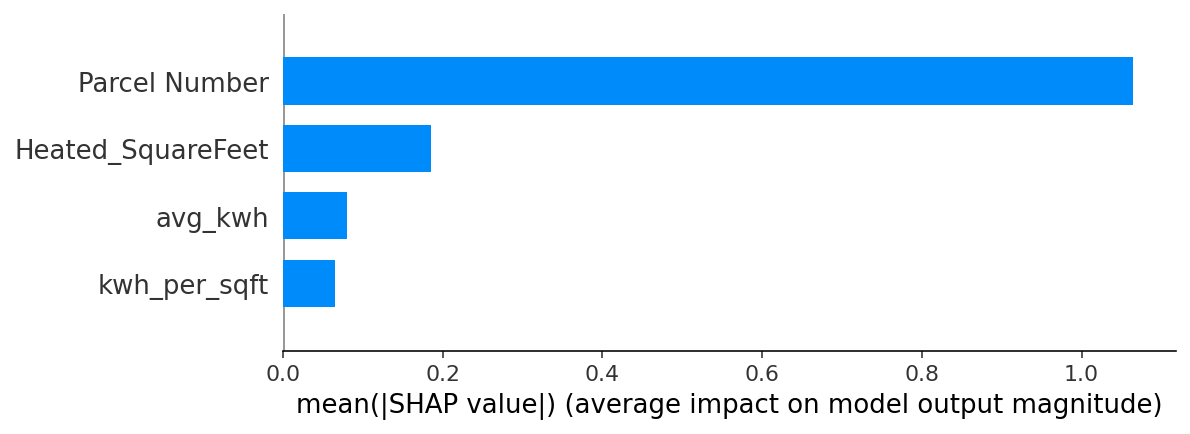

In [155]:
shap_values = shap.TreeExplainer(rf).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

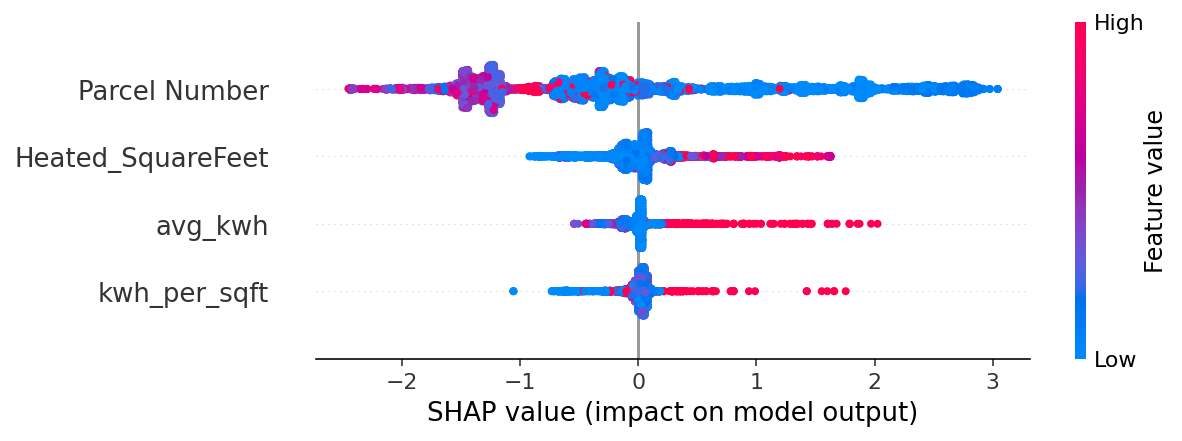

In [156]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_test)
# f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

<h4>Generate efficiency investement index predictions df for test set for Dash</h4>

In [157]:
y_hat_test = rf.predict(X_test)

In [162]:
X_test_pred = X_test
X_test_pred['pred_code_release'] = y_hat_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [167]:
#8615

X_test_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8615 entries, 5884 to 7186
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_kwh            8615 non-null   float64
 1   Parcel Number      8615 non-null   int64  
 2   Heated_SquareFeet  8615 non-null   float64
 3   kwh_per_sqft       8615 non-null   float64
 4   pred_code_release  8615 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 403.8 KB


<h4>Export predictions dataframe</h4>

In [160]:
# export predictions data for use in the carbon zero application
X_test_pred.to_csv(r'stationary-data/X_test_pred.csv', header=True)